# Perform inference with the component

After performing the evaluation in [Notebook 2: Evaluate LaREx](https://git.irt-systemx.fr/confianceai/ec_3/n6_monitoring/component-latent-space/ood-latent-space/-/blob/4-finish-library/examples/2_example_deeplab_segmentation_analysis.ipynb?ref_type=heads), we concluded that using LaREM with 256 PCA components seemed like a good configuration. Now we will see how to: 
 * Build a threshold for InD/OoD classification using a 95% confidence
 * Perform inference on new unseen images
 * Obtain the confidence score.
 * Visualize predictions 
 * Classify images as InD/OoD using the threshold 

In [1]:
import torch
from torchvision import transforms
import numpy as np
from os.path import join as op_join
from PIL import Image
from matplotlib import pyplot as plt
from deeplab_v3p import DeepLabV3PlusModule
from ls_ood_detect_cea.uncertainty_estimation import Hook, LaRExInference, MCSamplerModule, LaREMPostprocessor
from ls_ood_detect_cea import apply_pca_ds_split
from examples.dataset_utils import WoodScapeDataModule 

In [2]:
# Inference parameters
entropy_samples_folder = "./entropy/"
ind_dataset_name = "woodscapes"
layer_type = "Conv"
ws_dlv3p_path = "./checkpoints/last.ckpt"
MC_SAMPLES = 16
N_PCA_COMPONENTS = 256
ind_sample_image_path = "./test_images/00164_RV.png"
ood_sample_image_paths = ["./test_images/0094_RV.png", "./test_images/airport.jpg"]
z_95 = 1.645  # z score for 95% confidence
IMG_SIZE = (483, 640)  # Train image size
ws_dlv3p_norm_mean = [0.485, 0.456, 0.406]
ws_dlv3p_norm_std = [0.229, 0.224, 0.225]

# Load dataset module for results visualization

In [3]:
# Woodscape module necessary to visualize predictions
cmap = {0: [0, 0, 0],  # "void"
        1: [128, 64, 128],  # "road",
        2: [69, 76, 11],  # "lanemarks",
        3: [0, 255, 0],  # "curb",
        4: [220, 20, 60],  # "person",
        5: [255, 0, 0],  # "rider",
        6: [0, 0, 142],  # "vehicles",
        7: [119, 11, 32],  # "bicycle",
        8: [0, 0, 230],  # "motorcycle",
        9: [220, 220, 0]  # "traffic_sign",
        }
# InD high resolution
ws_dm_normal_dlv3p = WoodScapeDataModule(dataset_dir='./Woodscapes_dataset/',
                                         img_size=IMG_SIZE,
                                         batch_size=1,
                                         default_transforms=True,
                                         label_colours=cmap,
                                         norm_mean=ws_dlv3p_norm_mean,
                                         norm_std=ws_dlv3p_norm_std,
                                         seed=9290,
                                         drop_last=True)
ws_dm_normal_dlv3p.setup()

DATASET Shuffle Random SEED:  9290


# Train the component modules with the selected parameters

## Load InD training and test entropies

We train the component using the same train, validation and test entropy samples used during the evaluation (no need to extract more features, they were already extracted in [Notebook 1: extract MCDz samples](https://git.irt-systemx.fr/confianceai/ec_3/n6_monitoring/component-latent-space/ood-latent-space/-/blob/4-finish-library/examples/1_example_deeplab_segmentation_samples_extraction.ipynb?ref_type=heads))

In [4]:
# Load InD train entropies
ind_data_dict = {
    "h_z_train": np.load(file=op_join(entropy_samples_folder, f"{ind_dataset_name}_h_z_train.npy")),
    "h_z": np.concatenate(
        (
            np.load(file=op_join(entropy_samples_folder, f"{ind_dataset_name}_h_z_test.npy")),
            np.load(file=op_join(entropy_samples_folder, f"{ind_dataset_name}_h_z_valid.npy"))
        )
    )
}

## Train PCA module with the specified number of components, and LaREM postprocessor 

In [5]:
# Train PCA module and transform InD train samples
pca_ind_train, pca_transformation = apply_pca_ds_split(
    samples=ind_data_dict["h_z_train"],
    nro_components=N_PCA_COMPONENTS
)

# Setup LaREM postprocessor with the PCA transformed features
larem_ds_shift_detector = LaREMPostprocessor()
larem_ds_shift_detector.setup(pca_ind_train)

## Calculate threshold using an InD test set

In [6]:
# Calculate scores for the InD test set
test_ind_larem = larem_ds_shift_detector.postprocess(pca_transformation.transform(ind_data_dict["h_z"]))
# Calculate threshold
mean_ind_larem, std_ind_larem = np.mean(test_ind_larem), np.std(test_ind_larem)
# Here we use the 95% confidence z score
threshold_larem = mean_ind_larem - (z_95 * std_ind_larem) 
print(f"Threshold: {threshold_larem}")

Threshold: -314.56979079433347


Text(0.5, 1.0, 'Test set empirical LaREM score distribution')

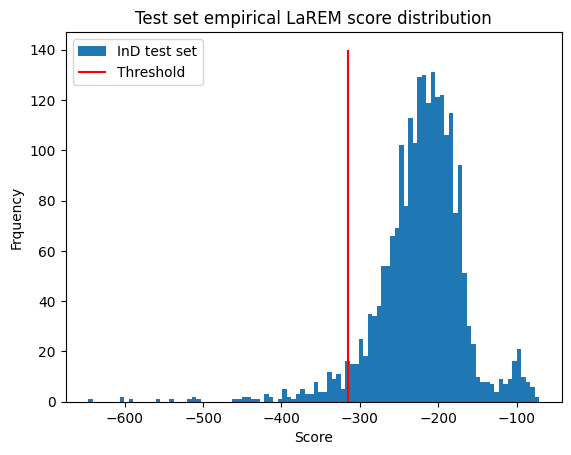

In [7]:
plt.hist(test_ind_larem, bins=100, label="InD test set")
plt.vlines(x=threshold_larem, ymin=0, ymax=140, colors='r', label="Threshold")
plt.legend()
plt.xlabel("Score")
plt.ylabel("Frquency")
plt.title("Test set empirical LaREM score distribution")

In [8]:
# Check that threshold is correctly calculated
print(f"Samples above threshold: {round(100 * (test_ind_larem > threshold_larem).sum() / test_ind_larem.shape[0], 2)} %") 

Samples above threshold: 95.36 %


With this threshold 95% of the InD samples are above, and samples below the threshold will be considered OoD during inference.

# Load Deeplabv3+ Woodscape Trained Model to perform inference

In [9]:
# Load model
ws_dlv3p_model = DeepLabV3PlusModule.load_from_checkpoint(checkpoint_path=ws_dlv3p_path)
# Send to device and activate dropblock
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ws_dlv3p_model.deeplab_v3plus_model.to(device)
ws_dlv3p_model.deeplab_v3plus_model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## Add Hook Deeplabv3+ Woodscape

In [11]:
ws_dlv3p_hook_dropblock2d_layer = Hook(ws_dlv3p_model.deeplab_v3plus_model.drop_block1)

# Instantiate inference module

In [12]:
# Instantiate Inference module and sampler
larem_inference_module = LaRExInference(
    dnn_model=ws_dlv3p_model.deeplab_v3plus_model,
    detector=larem_ds_shift_detector,
    mcd_sampler=MCSamplerModule,
    pca_transform=pca_transformation,
    mcd_samples_nro=MC_SAMPLES,
    layer_type=layer_type
)

# Load images

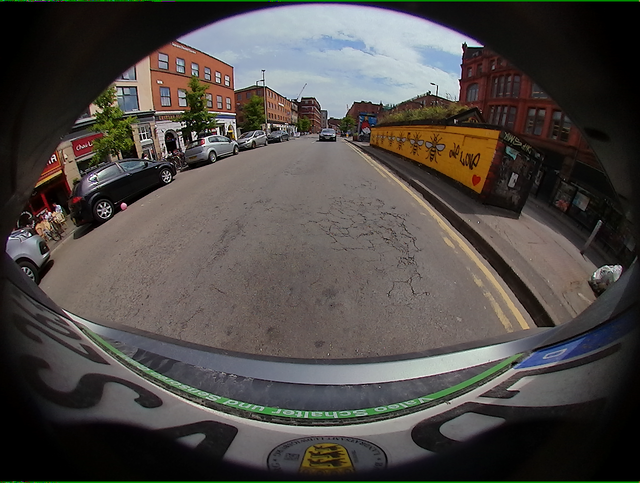

In [13]:
# Load test images
ind_img = Image.open(ind_sample_image_path)
ood_img0 = Image.open(ood_sample_image_paths[0])
ood_img1 = Image.open(ood_sample_image_paths[1])

# Apply same transformations as test
woodscape_img_transforms = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=ws_dlv3p_norm_mean,
            std=ws_dlv3p_norm_std,
        ),
    ]
)
ind_tensor_img = woodscape_img_transforms(ind_img).unsqueeze(0)  # Unsqueeze to make the image batch 1
ood_tensor_img0 = woodscape_img_transforms(ood_img0).unsqueeze(0)
ood_tensor_img1 = woodscape_img_transforms(ood_img1).unsqueeze(0)
# Visualize Ind image
ind_img

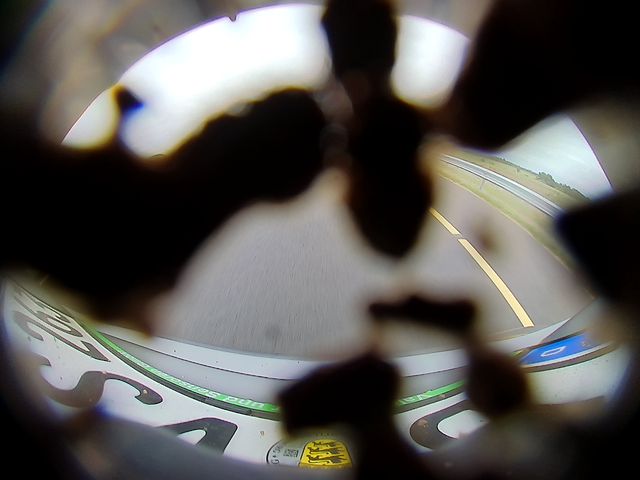

In [14]:
# Visualize ood images
ood_img0

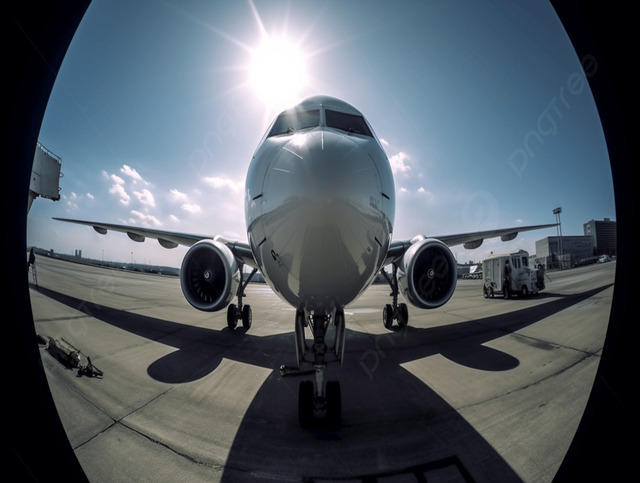

In [15]:
# Visualize ood images
ood_img1

We see here two types of distribution shifts: 
* First, the mud hides parts of the visual field, hindering the network from making predictions on such areas, which can be considered as covariate shift.
* Second, the image is correct (no noise or hidden parts of the visual field) but the content is out of the contexts of the trained network, and contains objects the network is not trained on (the plane), which can be considered as a semantic shift.

Let us see if the method can correctly classify all three images.

# Perform inference and get confidence score

In [16]:
# Perform inference and get confidence scores
torch.manual_seed(0)  # Set seed for reproducibility tests, but method should work with any seed
ind_prediction, ind_img_score = larem_inference_module.get_score(ind_tensor_img, layer_hook=ws_dlv3p_hook_dropblock2d_layer)
ood_prediction0, ood_img_score0 = larem_inference_module.get_score(ood_tensor_img0, layer_hook=ws_dlv3p_hook_dropblock2d_layer)
ood_prediction1, ood_img_score1 = larem_inference_module.get_score(ood_tensor_img1, layer_hook=ws_dlv3p_hook_dropblock2d_layer)

## Visualize predictions and classify samples as InD or OoD

In [17]:
# Transform prediction maps to visualize predictions
argmax_pred_ind = torch.argmax(ind_prediction.squeeze(0), dim=0)
argmax_pred_ood0 = torch.argmax(ood_prediction0.squeeze(0), dim=0)
argmax_pred_ood1 = torch.argmax(ood_prediction1.squeeze(0), dim=0)
ind_pred_img = ws_dm_normal_dlv3p.woodscape_ds_valid.decode_segmap(
    argmax_pred_ind.cpu().numpy()
)
ood_pred_img0 = ws_dm_normal_dlv3p.woodscape_ds_valid.decode_segmap(
    argmax_pred_ood0.cpu().numpy()
)
ood_pred_img1 = ws_dm_normal_dlv3p.woodscape_ds_valid.decode_segmap(
    argmax_pred_ood1.cpu().numpy()
)

Text(0.5, 0.98, 'InD image')

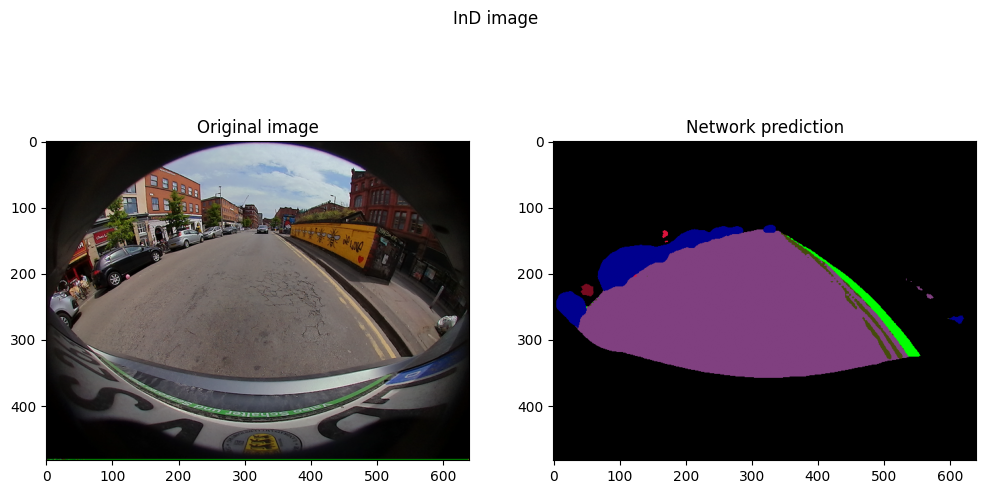

In [18]:
# InD image predicted map
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
axs[0].imshow(ind_img)
axs[0].set_title("Original image")
axs[1].imshow(ind_pred_img)
axs[1].set_title("Network prediction")
fig.suptitle('InD image')

In [19]:
# InD image confidence score
print(f"InD test image score: {ind_img_score}, score above threshold: {ind_img_score > threshold_larem}")

InD test image score: [-205.08284616], score above threshold: [ True]


For the InD image we can see the LaREM confidence score is above the threshold 

Text(0.5, 0.98, 'OoD image 1')

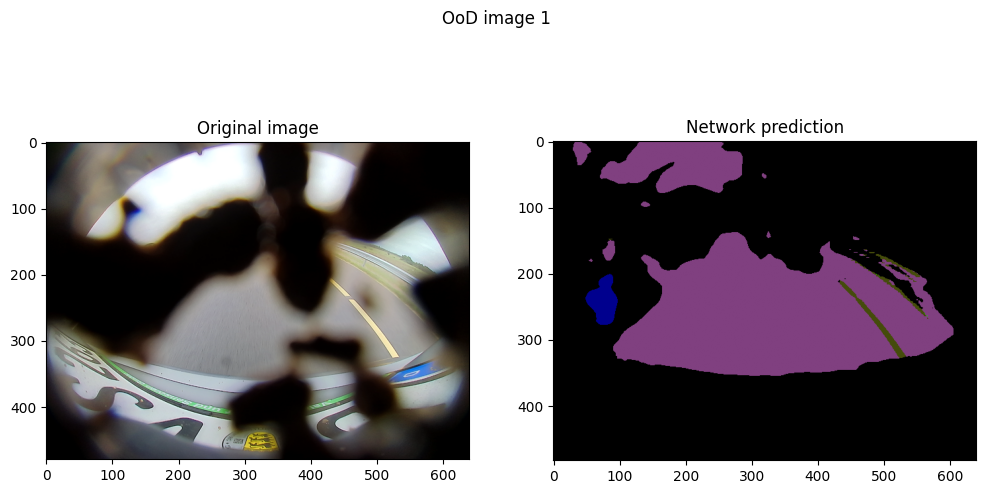

In [20]:
# OoD image 0
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
axs[0].imshow(ood_img0)
axs[0].set_title("Original image")
axs[1].imshow(ood_pred_img0)
axs[1].set_title("Network prediction")
fig.suptitle('OoD image 1')

In [21]:
print(f"OoD test image score: {ood_img_score0}, score above threshold: {ood_img_score0 > threshold_larem}")

OoD test image score: [-720.85013804], score above threshold: [False]


Text(0.5, 0.98, 'OoD image 2')

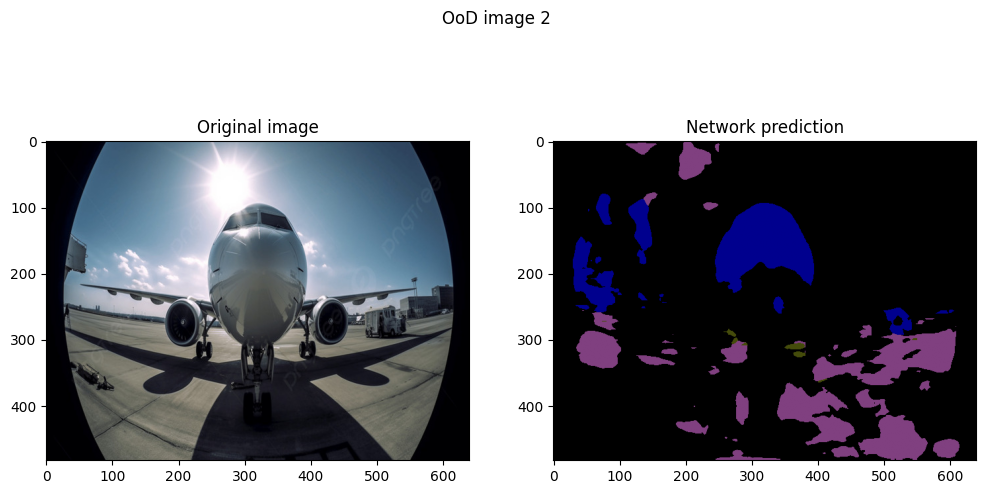

In [22]:
# OoD image 1
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
axs[0].imshow(ood_img1)
axs[0].set_title("Original image")
axs[1].imshow(ood_pred_img1)
axs[1].set_title("Network prediction")
fig.suptitle('OoD image 2')

In [23]:
print(f"OoD test image score: {ood_img_score1}, score above threshold: {ood_img_score1 > threshold_larem}")

OoD test image score: [-532.63886248], score above threshold: [False]


In conclusion, we can see that for the OoD images the LaREM confidence score is below the threshold in both cases: of covariate shift and semantic shift

For these images, the confidence score warns us that we can not trust the input images. Moreover, the predictions support the obtained confidence scores given the inconsistent and unreliable predictions.